# Contextual Variables (Explanatory Layer)
Since we know where the hotspots are, we can investigate why they exist:
- Include exposure variables (child size at birth, gestational age, antenatal care, maternal age, wealth, education, water source, place of birth, etc.)
- After clustering by mortality was discoverd we can model mortality/morbidity globally and locally
- global regression model with global covariates will be used to see general relationships across the entire country.
- Since hotspots/cold spots exist (high-mortality clusters vs. low-mortality clusters), it suggests the global relationship may mask local variations.
- I will study hotspots separately from cold spots to see if the predictors differ.

In [3]:
%pip install folium
%pip install esda libpysal

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/KR_modified_df.csv")

[![Screenshot-2025-08-23-at-11-55-14-PM.png](https://i.postimg.cc/yxryFNFN/Screenshot-2025-08-23-at-11-55-14-PM.png)](https://postimg.cc/Cnk80Sry)
This is Mortality Rate Geographic Clustering

[![Screenshot-2025-08-23-at-11-55-44-PM.png](https://i.postimg.cc/52DKhsQt/Screenshot-2025-08-23-at-11-55-44-PM.png)](https://postimg.cc/9DtBTtp3)
This is Morbidity (Sickness) Rates Geographic clustering

# Why Logistic Regression for Mortality Prediction?
The central research question guiding this analysis is whether there is a geographic clustering of mortality in Somalia, and if so, what underlying factors contribute to the higher likelihood of death in specific regions. Initial spatial analysis identified hotspots of mortality (e.g., Togdheer and Sool administrative regions), which suggests that geography may interact with social, demographic, and environmental factors to influence mortality.


To further investigate these relationships, a logistic regression model is employed, with death (yes/no) as the binary dependent variable. Logistic regression is particularly well-suited for this context because:


1. **Binary Outcome**: Mortality is inherently a dichotomous outcome — either the child died or survived. Logistic regression directly models the probability of death given a set of predictors.
2. **Multiple Predictors**: Mortality is rarely explained by a single factor. By including a range of predictors such as maternal education, household water source, age of the respondent, place of birth, and geographic/spatial indicators, the model allows us to test the combined and individual contributions of each variable to mortality risk.
3. **Spatial Effects**: Because earlier findings showed significant geographic clustering, a spatially derived weight (from queen contiguity or similar measures) is incorporated as an additional predictor. This enables us to examine whether location, beyond individual and household factors, systematically predicts mortality.
4. **Exploratory Insight**: While multicollinearity and other model limitations may prevent definitive causal interpretations, logistic regression provides a directional understanding. It helps identify which predictors are strongly associated with mortality globally across Somalia, thereby guiding more focused, region-specific models.
5. **Foundation for Local Analysis**: The global model offers a baseline picture of how geography and social determinants jointly shape mortality risk. Based on its findings, further separate logistic regression models can be applied to specific hotspots (e.g., Togdheer, Sool) to better understand the unique local drivers of high mortality rates.

In [5]:
# Measuring Mortality
mortality = 1 - df.groupby('regions')['B5'].sum() / df['regions'].value_counts()
mortality_df = mortality.reset_index()
mortality_df.columns = ["regions", "mortality"]
mortality_df

,regions,mortality
0,Awdal,0.058824
1,Bakool,0.050832
2,Banadir,0.029185
3,Bari,0.056564
4,Bay,0.077121
5,Galgaduud,0.052036
6,Gedo,0.036120
7,Hiiraan,0.035806
8,Lower Juba,0.048828
9,Middle Shebelle,0.042735


# Building Spatial Weights
Since mortality was found to be spatially clustered with (Moran’s I = 0.303 & p-value = 0.042) I want to include this relationship in my logistic regression to be able to predict mortality.

Using Queens contiguity, I will create weight matrix W where each row corresponds to a region, and each column shows which neighbors are connected.

In [6]:
import geopandas as gpd
import libpysal
from libpysal.weights import Queen

gdf = gpd.read_file("/content/geoBoundaries-SOM-ADM1.geojson")

gdf = gdf.merge(mortality_df, left_on='shapeName', right_on='regions')
w = Queen.from_dataframe(gdf) # Now each region has neighbors and their relative influence.

# standardize (so each row sums to 1)
w.transform = "R"


/tmp/ipython-input-3703802244.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf) # Now each region has neighbors and their relative influence.


To give each region a number that represent its neighbors, I will create a spatial lag. (for each region, the average of the outcome "mortality" in its neighbors)

If Region A has 3 neighbors, and their mortality rates are 0.2, 0.3, 0.4, then A’s spatial_lag_mortality = (0.2+0.3+0.4)/3 = 0.3.

In [7]:
gdf["spatial_lag_mortality"] = libpysal.weights.spatial_lag.lag_spatial(w, gdf["mortality"])

In [8]:
df = df.merge(gdf[["regions", "spatial_lag_mortality"]], on="regions", how="left")


## Establishing a Simple Classifier (Baseline)

In [9]:
def plot_cm_as_image(cm):
    conf_matrix=pd.DataFrame(data=cm, columns=['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d',cmap="YlGnBu")

In [10]:
df['death'] = 1 - df['B5']
df['death'].value_counts()


,count
death,
0.0,15946
1.0,943


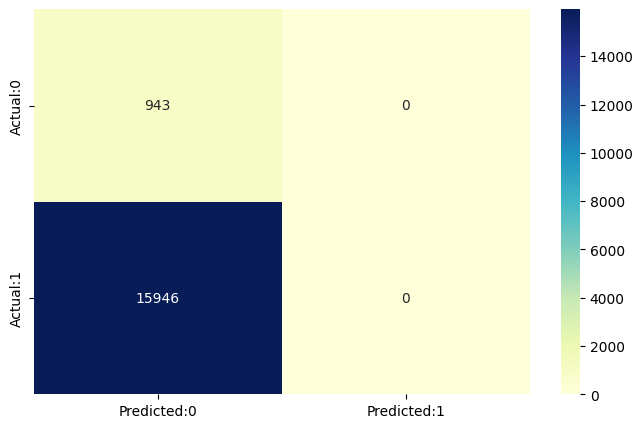

In [11]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = confusion_matrix(df["B5"], [0]*len(df))
plot_cm_as_image(cm)

In [12]:
print("Accuracy =", 943/len(df))

Accuracy = 0.055835158979217245


## Preparing the data


### Factors available to be used as predictors:
- Geographic Location (I'll use both spatial lag and region)
- Sickness (morbidity as a value)
- Responsive dimensions (Seeking treatment & Help)
- Exposure dimensions (ANC & birth weight)
- Contextual + Environmental risk factors
  - Education
  - Wealth
  - Water source
  - Age of Mother
  - Place of birth

You might think that we're predicting mortality using mortality (using a dependent variable to predict itself), because we used the relationship between mortality and geographic location spatially, but NO.

The spatial lag we have is calculated as the weighted average of morality in neighboring regions. So for every region, the spatial lag does not include its own mortality, only the neighbors. [FYI. models like SLM "Spatial Lag Models" include spatial lag as a predictor all the time]


We will also *stratify* our split on the predicted variable, meaning that the data is split to preserve the ratio of B5 in both the training and testing sets.

In [13]:
df.head()

,Unnamed: 0,idx,V012,V024,V026,V102,V106,V113,V190,B5,...,residence,diarrhea_treatment,diarrhea_help,fever_cough_ttt,fever_cough_help,ANC,response,regions,spatial_lag_mortality,death
0,1,1,35.0,11.0,1.0,1.0,0,13.0,3.0,1.0,...,Urban,1,0,0,0,0,1,Awdal,0.050654,0.0
1,2,2,35.0,11.0,1.0,1.0,0,13.0,3.0,0.0,...,Urban,1,0,0,0,0,1,Awdal,0.050654,1.0
2,3,3,35.0,11.0,1.0,1.0,0,13.0,3.0,0.0,...,Urban,1,0,0,0,0,1,Awdal,0.050654,1.0
3,4,4,35.0,11.0,1.0,1.0,0,13.0,3.0,0.0,...,Urban,0,0,0,0,0,0,Awdal,0.050654,1.0
4,5,5,35.0,11.0,1.0,1.0,0,13.0,3.0,0.0,...,Urban,1,0,0,0,0,1,Awdal,0.050654,1.0


- "spatial_lag_mortality"
- V012: Age of Mother
- V024: Region
- V102: Place of residence
- V106: wealth quantile
- V113: source of water
- V190: highest education
- M18: size of birth
- ANC
- M15: Place of birth
- sickness
- response



We will also *stratify* our split on the predicted variable, meaning that the data is split to preserve the ratio of B5 in both the training and testing sets.

In [14]:
df.shape[0]

16889

In [15]:
from sklearn.model_selection import train_test_split

# Split the data
X = df[["spatial_lag_mortality", "V012", "V024", "V102", "V106", "V113", "V190", "M18", "ANC", "M15",
        "sickness", "response"]]
y = df['B5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df['B5'])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05),
            'penalty': ['l2','l1'],
            'solver': ['liblinear']}

# Define the parameters for the model
gs = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                return_train_score=True,
                param_grid=param_grid,
                scoring='roc_auc',
                cv=5, verbose = 0)
## Fit the model
random.seed(42)
gs.fit(X_train, y_train)
m_lr = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'C': np.float64(0.401), 'penalty': 'l2', 'solver': 'liblinear'}


In [17]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
            'coefficient':m_lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 0


,feature,coefficient
11,response,-2.311856
8,ANC,-0.275866
5,V113,-0.001235
9,M15,0.002436
2,V024,0.011202
7,M18,0.020122
1,V012,0.030324
4,V106,0.085878
0,spatial_lag_mortality,0.124807
6,V190,0.195072


Top 3 coefficents are:
- Response
- sickness
- ANC

It was predicted that variables are probably going to show small coefficients, because it's difficult to use a global measure of mortality when different areas have different contexts.
Interestingly sickness and response which both are somehow related to morbidity have the highest coefficients.
Response to be exact has the highest coefficient. This might hint that receiving care, and the support of the healthcare system is a great indicator or the outcome.

But there's a noticable problem with my coefficient, some numbers are mixed. could it make sense that sickness increase likelihood to be alive, and response does the opposite? No, this is multicollinearity

                       spatial_lag_mortality      V012      V024      V102  \
spatial_lag_mortality               1.000000  0.000480 -0.720080 -0.113187   
V012                                0.000480  1.000000 -0.029055  0.015313   
V024                               -0.720080 -0.029055  1.000000  0.118797   
V102                               -0.113187  0.015313  0.118797  1.000000   
V106                                0.026425 -0.124739 -0.046679 -0.251867   
V113                                0.188869 -0.019032 -0.057765 -0.051359   
V190                                0.059526 -0.031165 -0.091538 -0.671087   
M18                                 0.098750  0.022877 -0.090031 -0.009670   
ANC                                 0.053431 -0.053893 -0.097033 -0.188481   
M15                                 0.041263 -0.032139 -0.088786 -0.213006   
sickness                           -0.018080 -0.027518  0.040260 -0.061376   
response                            0.102143  0.044432 -0.112239

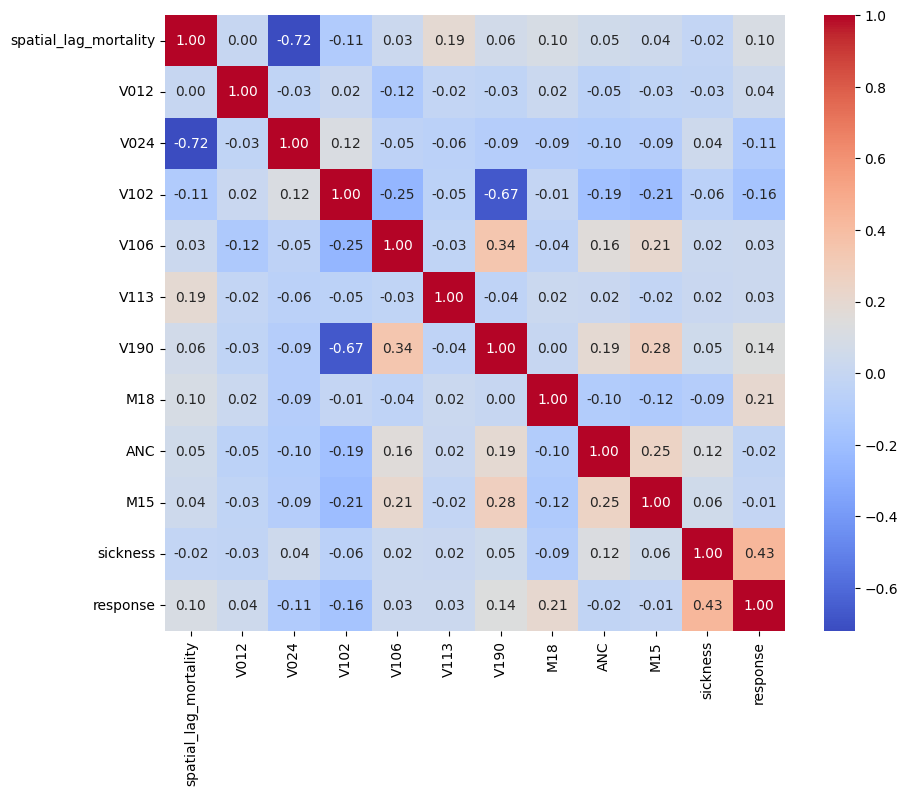

In [18]:
corr_matrix = X.corr()
print(corr_matrix)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

- Spatial lag of mortality and region: Because mortality patterns cluster regionally. Keeping both may not add much new info.
- Residence (urban/rural/nomadic) and wealth quintile: These also overlap—urban tends to be richer, nomadic tends to be poorer, etc.

I will drop region (V024) and wealth quantile (V190).

Also to reduce noise and multicollinearity while keeping interpretability, The WHO/UNICEF Joint Monitoring Programme (JMP) on water, sanitation, and hygiene (WASH) uses exactly the improved/unimproved classification for water resource. I'm going to change the numbers into binary data.

In [19]:
unimproved_water = [32, 42, 43, 96]
df['water_source'] = np.where(df['V113'].isin(unimproved_water), 0, 1)

In [20]:
df['place_of_birth'] = np.where(df['M15'] == 11, 0, 1)

I think it would be wise to also consider conflict, a good measure that can be used to compare regions affected with conflict to one another, is by using the displacement rates.

Most of the data were obtained between 2018 and 2019, and the mean is 2018. I think it's safer to consider 2018 data. In 2019 displacement didn't occur on a large scale until October 2019.

The displacement data used in this analysis was obtained from the United Nations High Commissioner for Refugees (UNHCR) Operational Data Portal. Specifically, the dataset comes from the UNHCR Displacement Tracking and Visualization platform, which provides regularly updated information on internal displacement and refugee movements.

In [21]:
departures = {
    "Banadir": 34000,
    "Sanaag": 15000,
    "Sool": 50000,
    "Togdheer": 24000,
    "Woqooyi Galbeed": 3000,
    "Bakool": 74000,
    "Lower Juba": 19000,
    "Gedo": 59000,
    "Bari": 17000,
    "Nugaal": 4000,
    "Mudug": 27000,
    "Galgaduud": 25000,
    "Middle Shebelle": 55000,
    "Awdal": 14000,
    "Hiiraan": 165000,
    "Bay": 75000
}



arrivals = {
    "Banadir": 226000,
    "Sanaag": 10000,
    "Sool": 64000,
    "Togdheer": 9000,
    "Woqooyi Galbeed": 7000,
    "Bakool": 57000,
    "Lower Juba": 21000,
    "Gedo": 57000,
    "Bari": 25000,
    "Nugaal": 4000,
    "Mudug": 25000,
    "Galgaduud": 28000,
    "Middle Shebelle": 37000,
    "Awdal": 14000,
    "Hiiraan": 159000,
    "Bay": 87000
}

In [22]:
df['departures'] = df['regions'].map(departures)
df['arrivals'] = df['regions'].map(arrivals)

In [23]:
X = df[["spatial_lag_mortality", "V012", "V102", "V106", "M18", "ANC", "place_of_birth", "water_source", "departures", "arrivals",
        "sickness", "response"]]
y = df['B5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df['B5'])

In [24]:
# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05),
            'penalty': ['l2','l1'],
            'solver': ['liblinear']}

# Define the parameters for the model
gs = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                return_train_score=True,
                param_grid=param_grid,
                scoring='roc_auc',
                cv=5, verbose = 0)
## Fit the model
random.seed(42)
gs.fit(X_train, y_train)
m_lr = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'C': np.float64(0.30100000000000005), 'penalty': 'l1', 'solver': 'liblinear'}


In [25]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
            'coefficient':m_lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 2


,feature,coefficient
11,response,-2.301945
5,ANC,-0.223988
7,water_source,-0.013217
8,departures,-0.000001
0,spatial_lag_mortality,0.000000
2,V102,0.000000
9,arrivals,0.000003
4,M18,0.025692
1,V012,0.029230
6,place_of_birth,0.115647


Train AUC: 0.760
Test AUC: 0.776


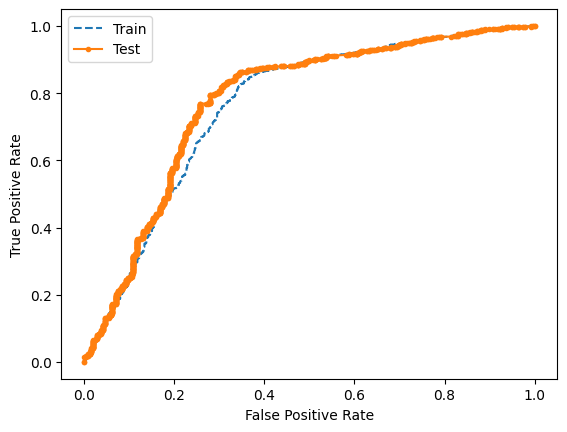

In [26]:
from sklearn import metrics


train_pred = m_lr.predict_proba(X_train)[:,1]
test_pred = m_lr.predict_proba(X_test)[:,1]

print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))

train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
plt.plot(test_fpr, test_tpr, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Train Accuracy: 0.944
Test Accuracy: 0.944


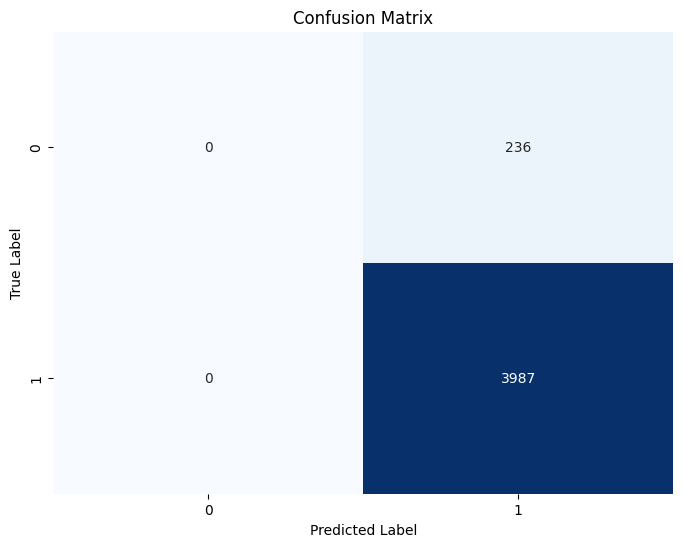

In [27]:
t = 0.5
print("Train Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

# If we wanted to get all of the elements of the confusion matrix, we could pull them like this:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, test_pred > t).ravel()

# Plot the confusion matrix on the test set
cm = metrics.confusion_matrix(y_test, test_pred > t)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Since the data is heavily imbalanced, and death is considered a rare event the model just predicts "1" all the time, and gets away with that with a high AUC rate.

XGBoost is one of the go-to algorithms for rare events as it can handle imbalance, through scale_pos_weight. This basically tells the algorithm how much more to “care” about the minority class (“death”).

In [28]:
y = df['death']


In [29]:
%pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Suppose X = features, y = labels (0=alive, 1=death)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight
neg, pos = np.bincount(y_train)
scale = neg / pos
print("scale_pos_weight:", scale)

# Set up model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    use_label_encoder=False,
    scale_pos_weight=scale,
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


scale_pos_weight: 16.433548387096774
[[2828  382]
 [  94   74]]
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      3210
         1.0       0.16      0.44      0.24       168

    accuracy                           0.86      3378
   macro avg       0.57      0.66      0.58      3378
weighted avg       0.93      0.86      0.89      3378



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:02:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Class 0.0 (alive)

**Precision**: 0.97 → when model says “alive,” it’s right 97% of the time.

**Recall**: 0.86 → it correctly catches 86% of actual alive cases.

**F1**: 0.91 → strong.

### Class 1.0 (death)

**Precision**: 0.15 → when model says “death,” it’s wrong most of the time (85% false alarms).

**Recall**: 0.42 → it catches less than half of actual deaths, but misses the other half.

**F1**: 0.22 → very weak compared to alive class.

### Macro average (treats both classes equally):

**Precision:** 0.56

**Recall**: 0.64

**F1**: 0.57

I think it's difficult to create a predictive model from such general data as expected.

(trying to predict individual child death across the whole dataset) are often hard to make accurate because mortality is a rare event, influenced by many interacting and unmeasured factors (conflict, nutrition, healthcare access, maternal education, etc.). Even strong models like XGBoost can struggle when the signal-to-noise ratio is low.

Let's try predicting death in the hotspots vs the coldspots.

In [30]:
df["sickness_x_response"] = df["sickness"] * df["response"]

In [31]:
df_hotspots = df[df['regions'] == 'Togdheer']

In [32]:
# Split the data
X = df_hotspots[["V102", "water_source", "V190", "M18", "ANC", "place_of_birth",
        "sickness_x_response"]]
y = df_hotspots['death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_hotspots['death'])

In [33]:
# Define the grid that we want to search over
param_grid = {'C': np.arange(0.001, 1, 0.05),
            'penalty': ['l2','l1'],
            'solver': ['liblinear']}

# Define the parameters for the model
gs = GridSearchCV(LogisticRegression(random_state=42, max_iter = 1000),
                return_train_score=True,
                param_grid=param_grid,
                scoring='roc_auc',
                cv=5, verbose = 0)
## Fit the model
random.seed(42)
gs.fit(X_train, y_train)
m_lr = gs.best_estimator_
print("Best parameters: ", gs.best_params_)

Best parameters:  {'C': np.float64(0.9510000000000001), 'penalty': 'l1', 'solver': 'liblinear'}


In [34]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
            'coefficient':m_lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 1


,feature,coefficient
5,place_of_birth,-0.694028
0,V102,-0.496735
6,sickness_x_response,-0.252615
2,V190,-0.064828
4,ANC,-0.035962
1,water_source,0.000000
3,M18,0.115997


Train AUC: 0.669
Test AUC: 0.627


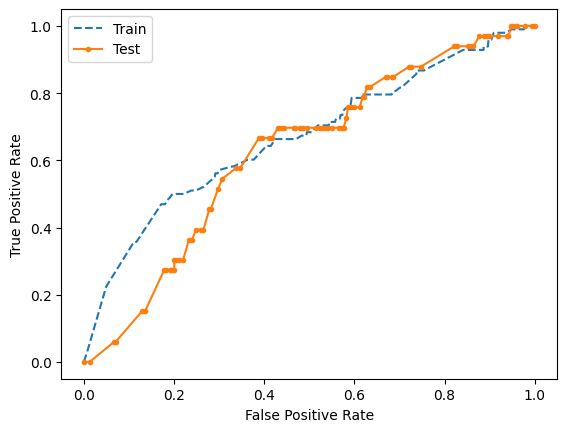

In [35]:
from sklearn import metrics


train_pred = m_lr.predict_proba(X_train)[:,1]
test_pred = m_lr.predict_proba(X_test)[:,1]

print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))

train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
plt.plot(test_fpr, test_tpr, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Train Accuracy: 0.904
Test Accuracy: 0.904


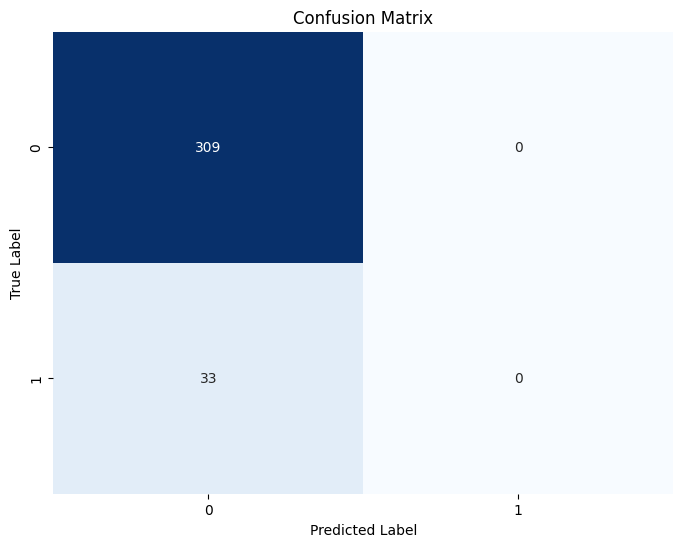

In [36]:
t = 0.5
print("Train Accuracy: %.3f" %  metrics.accuracy_score(y_train, train_pred > t))
print("Test Accuracy: %.3f" %  metrics.accuracy_score(y_test, test_pred > t))

# If we wanted to get all of the elements of the confusion matrix, we could pull them like this:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, test_pred > t).ravel()

# Plot the confusion matrix on the test set
cm = metrics.confusion_matrix(y_test, test_pred > t)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [37]:
# Precision & Recall
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)

Precision: 0.000
Recall: 0.000


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight
neg, pos = np.bincount(y_train)
scale = neg / pos
print("scale_pos_weight:", scale)

# Set up model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    use_label_encoder=False,
    scale_pos_weight=scale,
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

scale_pos_weight: 9.30188679245283
[[169  80]
 [ 14  11]]
              precision    recall  f1-score   support

         0.0       0.92      0.68      0.78       249
         1.0       0.12      0.44      0.19        25

    accuracy                           0.66       274
   macro avg       0.52      0.56      0.49       274
weighted avg       0.85      0.66      0.73       274



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:02:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Reapplying logistic regression on the whole dataset

In [39]:
from sklearn.model_selection import train_test_split

# Split the data
X = df[["spatial_lag_mortality", "V012", "V024", "V102", "V106", "V113", "V190", "M18", "ANC", "M15",
        "sickness", "response"]]
y = df['death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df['B5'])

In [40]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Create a logistic regression model
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)

#Calculating and printing the f1 score
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
confusion_matrix(y_test, pred_test)

The f1 score for the testing data: 0.29162916291629165


array([[3274,  713],
       [  74,  162]])

In [41]:
# Calculate precision and recall from the confusion matrix
# confusion_matrix(y_test, pred_test) gives [[tn, fp], [fn, tp]]
cm = confusion_matrix(y_test, pred_test)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.18514285714285714
Recall: 0.6864406779661016
Accuracy: 0.8136395927066067


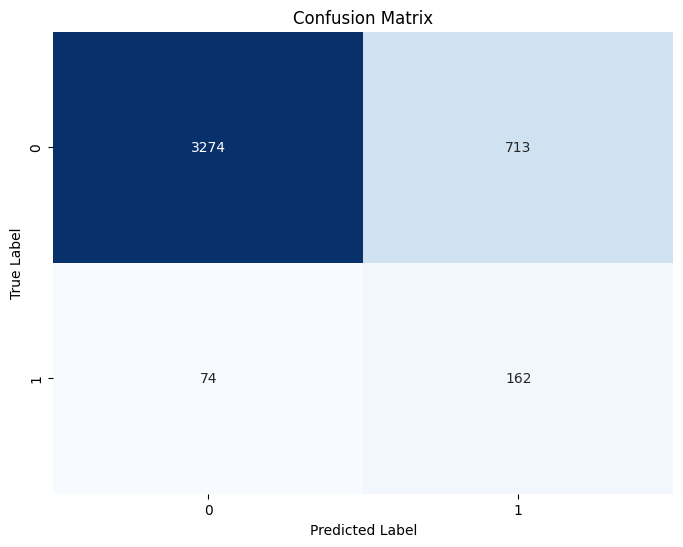

In [42]:

# Plot the confusion matrix on the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [43]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
            'coefficient':lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 0


,feature,coefficient
10,sickness,-1.439622
0,spatial_lag_mortality,-0.736357
3,V102,-0.180841
6,V190,-0.172325
4,V106,-0.080548
1,V012,-0.021880
7,M18,-0.014942
2,V024,-0.003106
9,M15,-0.000985
5,V113,0.002020


Train AUC: 0.767
Test AUC: 0.781


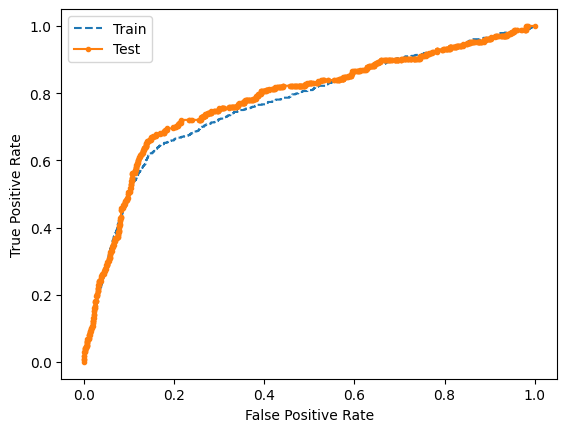

In [45]:

train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

print("Train AUC: %.3f" % metrics.roc_auc_score(y_train, train_pred))
print("Test AUC: %.3f" % metrics.roc_auc_score(y_test, test_pred))

train_fpr, train_tpr, _ = metrics.roc_curve(y_train, train_pred)
test_fpr, test_tpr, _ = metrics.roc_curve(y_test, test_pred)

# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, linestyle='--', label='Train')
plt.plot(test_fpr, test_tpr, marker='.', label='Test')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Let's try again using f1 with local model in Togdheer

In [46]:
# Split the data
X = df_hotspots[["spatial_lag_mortality", "V012", "V024", "V102", "V106", "V113", "V190", "M18", "ANC", "M15",
        "sickness", "response"]]
y = df_hotspots['death']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_hotspots['B5'])

In [47]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Create a logistic regression model
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)

#Calculating and printing the f1 score
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
confusion_matrix(y_test, pred_test)

The f1 score for the testing data: 0.3795620437956204


array([[231,  78],
       [  7,  26]])

In [48]:
# Calculate precision and recall from the confusion matrix
# confusion_matrix(y_test, pred_test) gives [[tn, fp], [fn, tp]]
cm = confusion_matrix(y_test, pred_test)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.25
Recall: 0.7878787878787878
Accuracy: 0.7514619883040936


In [49]:
# Let's look at the coefficients
coef_output = pd.DataFrame({'feature':X_train.columns,
            'coefficient':lr.coef_[0]})

print("Number of zeros: %d" % (coef_output.query('coefficient == 0').shape[0]))
coef_output.sort_values('coefficient')

Number of zeros: 0


,feature,coefficient
10,sickness,-1.880129
4,V106,-0.119134
9,M15,-0.094030
7,M18,-0.075523
2,V024,-0.033959
1,V012,-0.004128
0,spatial_lag_mortality,-0.000175
5,V113,0.005139
6,V190,0.026725
3,V102,0.071332
